In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import seaborn as sns
import cobra
import scipy.stats as st
import scipy
sys.path.append('../../code/')
import leakage
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import re

In [39]:
folder = Path('/Users/ssulheim/Library/CloudStorage/OneDrive-UniversitédeLausanne/UNIL/leakage/experimental work/KEIO_KO_growth_test_and_exometabolome_screening_240122/exometabolome')

In [40]:
fn = folder / 'SM_MPTA_Results.xlsx'
mapping_fn = folder.parent.parent /'sintef_sept_23/exometabolome'/'met_to_bigg.csv'
od_fn = folder / '..' / 'plan_240122.xlsx'
id_mapping_fn = folder / 'id_mapping.csv'

In [41]:
mapping_dict = pd.read_csv(mapping_fn, index_col = 0).to_dict()['BiGG ID']

In [42]:
id_mapping = pd.read_csv(id_mapping_fn, index_col=0).to_dict()['OD_ID']

In [43]:
id_mapping

{'SR_MPTA_020204_11A-2_WT_22': '11A-2: WT',
 'SR_MPTA_020204_11B-2_WT_23': '11B-2: WT',
 'SR_MPTA_020204_11C-2_WT_24': '11C-2: WT',
 'SR_MPTA_020204_12A-1_pool_A_25': '12A-1: pool',
 'SR_MPTA_020204_12B-1_pool_B_26': '12B-1: pool',
 'SR_MPTA_020204_12C-1_pool_C_27': '12C-1: pool',
 'SR_MPTA_020204_1A-2_aceE_1': '1A-2: aceE',
 'SR_MPTA_020204_1B-2_aceE_2': '1B-2: aceE',
 'SR_MPTA_020204_1C-2_aceE_3': '1C-2: aceE',
 'SR_MPTA_020204_2A-2_cyoD_4': '2A-2: cyoD',
 'SR_MPTA_020204_2B-2_cyoD_5': '2B-2: cyoD',
 'SR_MPTA_020204_2C-2_cyoD_6': '2C-2: cyoD',
 'SR_MPTA_020204_3A-2_lacA_7': '3A-2: lacA',
 'SR_MPTA_020204_3B-2_lacA_8': '3B-2: lacA',
 'SR_MPTA_020204_3C-2_lacA_9': '3C-2: lacA',
 'SR_MPTA_020204_4A-2_nuoA_10': '4A-2: nuoA',
 'SR_MPTA_020204_4B-2_nuoA_11': '4B-2: nuoA',
 'SR_MPTA_020204_4C-2_nuoA_12': '4C-2: nuoA',
 'SR_MPTA_020204_5A-2_pgi_13': '5A-2: pgi',
 'SR_MPTA_020204_5B-2_pgi_14': '5B-2: pgi',
 'SR_MPTA_020204_5C-2_pgi_15': '5C-2: pgi',
 'SR_MPTA_020204_6A-2_rpe_16': '6A-2: rpe',

In [44]:
df_raw = pd.read_excel(fn, skiprows=1)
# df_raw.set_index('Unnamed: 0', inplace=True)
df_raw['Metabolite'] = [x.rstrip() for x in df_raw['Unnamed: 0']]

In [45]:
value_cols = [x for x in id_mapping.keys() if not 'pool' in x]
count_df = df_raw[['Metabolite']+value_cols]

In [46]:
df = count_df.melt(id_vars='Metabolite', value_vars=value_cols, value_name='Count', var_name='Sample ID')

In [47]:
for met in count_df.Metabolite.unique():
    try:
        mapping_dict[met]
    except KeyError:
        print(met)

PYRIMIDINE
DIHYDROURACIL
N-ACETYLLEUCINE
N-ACETYLPHENYLALANINE
4-ACETAMIDOBUTANOATE
DETHIOBIOTIN
THYMINE
NICOTINATE
BIOTIN
METHYLTHIOADENOSINE
TRYPTAMINE
ADENOSINE
TRIMETHYLAMINE
CHOLINE
TYRAMINE
AICAR
OXOPROLINE
INOSINE
METHYLGUANIDINE
KYNURENATE
RIBOFLAVIN
ANTHRANILATE
GUANINE
N-ACETYLSERINE
XANTHURENATE
N-ACETYLPUTRESCINE
ETHANOLAMINE
EPINEPHRINE
TRIGONELLINE
ADENOSINE 3', 5'-CYCLIC PHOSPHATE
4-IMIDAZOLEACETATE
N-ALPHA-ACETYLLYSINE
CYCLIC GMP
GUANIDINOSUCCINATE
S-ADENOSYLHOMOCYSTEINE
OPHTHALMATE
HISTIDINOL
CADAVERINE
PUTRESCINE
1, 3-DIAMINOPROPANE
N,N,N-TRIMETHYLLYSINE
HEXANOATE
FAD
S-ADENOSYLMETHIONINE
ARGININE
STEAROYLCARNITINE (C18)
HEXANOYLCARNITINE (C6)
CARNITINE (C0)
SALICYLATE
PYRIDOXAL
URACIL
GLYCEROL
2-OXOBUTANOATE/ACETOACETATE
GLUCURONOLACTONE
HYPOXANTHINE
2, 5-DIHYDROXYBENZOATE
2-HYDROXYBUTYRATE
ALPHA-HYDROXYISOBUTYRATE
3-(4-HYDROXYPHENYL)PYRUVATE
XANTHINE
3-HYDROXYBUTYRATE
HYDROXYPHENYLLACTATE
3-HYDROXYPHENYLACETATE
PANTOTHENATE
OROTATE
cAMP
O-ACETYLSERINE
3-HYDROXYANTHR

In [48]:
df['Sample'] = df['Sample ID'].map(id_mapping)
df['Strain'] = [x.split(': ')[1] for x in df['Sample']]

In [49]:
order_d = {'WT':0, 'lacA':1, 'aceE':2, 'cyoD':3, 'nuoA':4, 'pgi':5, 'rpe':6, 'sucB':7}

In [50]:
df.sort_values(by='Strain', key=lambda x: x.map(order_d))

,Metabolite,Sample ID,Count,Sample,Strain
0,PYRIMIDINE,SR_MPTA_020204_11A-2_WT_22,47356.347137,11A-2: WT,WT
226,4-ACETAMIDOBUTANOATE,SR_MPTA_020204_11C-2_WT_24,36854.890278,11C-2: WT,WT
225,N-ACETYLPHENYLALANINE,SR_MPTA_020204_11C-2_WT_24,4190.114510,11C-2: WT,WT
224,N-ACETYLLEUCINE,SR_MPTA_020204_11C-2_WT_24,29141.727147,11C-2: WT,WT
223,DIHYDROURACIL,SR_MPTA_020204_11C-2_WT_24,11563.144639,11C-2: WT,WT
...,...,...,...,...,...
2438,CIS-ACONITATE,SR_MPTA_020204_8A-2_sucB_19,67769.910692,8A-2: sucB,sucB
2437,GLUCOSE-6-PHOSPHATE,SR_MPTA_020204_8A-2_sucB_19,0.000087,8A-2: sucB,sucB
2436,MALATE,SR_MPTA_020204_8A-2_sucB_19,8883.267359,8A-2: sucB,sucB
2434,SUCCINATE,SR_MPTA_020204_8A-2_sucB_19,1734.432309,8A-2: sucB,sucB


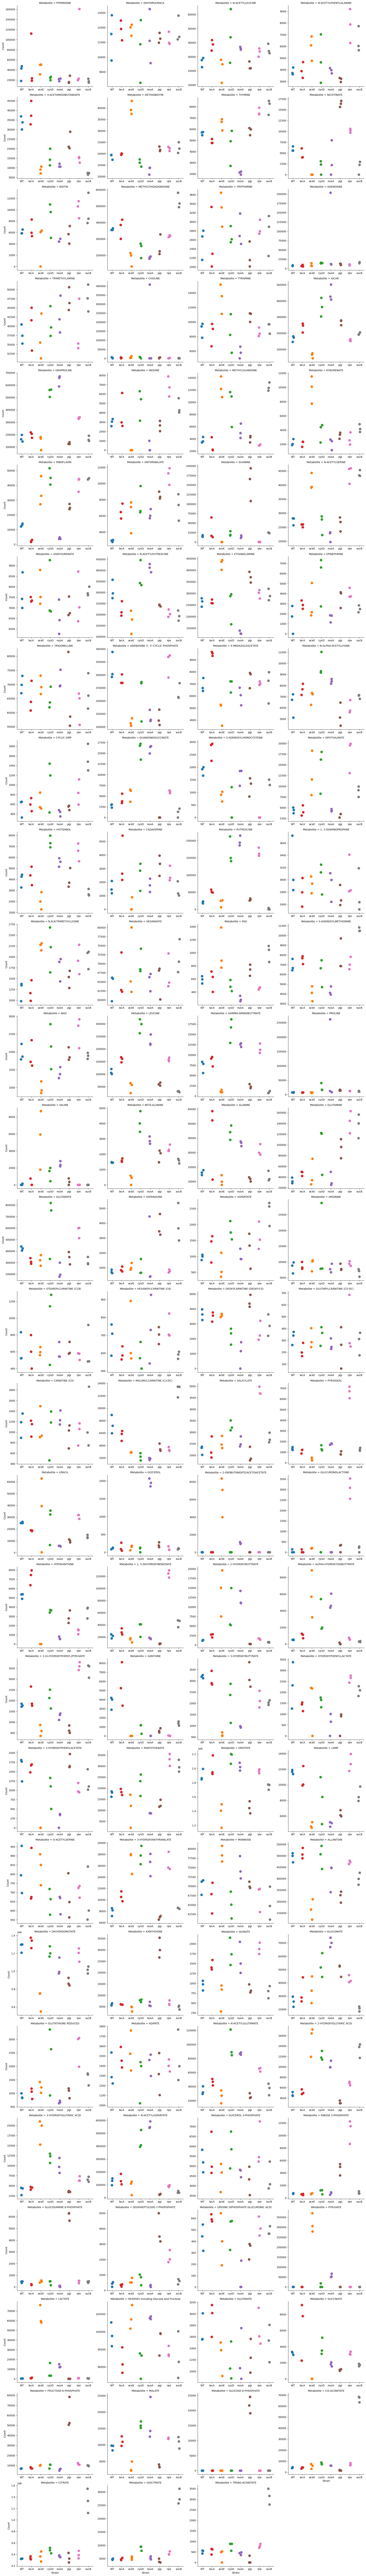

In [51]:
sns.catplot(data=df, x = 'Strain', y = 'Count', col='Metabolite', col_wrap=4, sharey=False, hue = 'Strain', sharex = False,  order=['WT', 'lacA', 'aceE', 'cyoD', 'nuoA', 'pgi', 'rpe', 'sucB'], s = 100) #log_scale=True,

In [52]:
count_df.set_index('Metabolite', inplace=True)

In [53]:
X = StandardScaler().fit_transform(count_df.T)

In [54]:
pca = PCA(n_components=3)

In [55]:
pca.fit(X)
Xn = pca.transform(X)

In [56]:
pca.explained_variance_ratio_

array([0.20824866, 0.19216155, 0.15184717])

In [57]:
set(id_mapping.values())

{'11A-2: WT',
 '11B-2: WT',
 '11C-2: WT',
 '12A-1: pool',
 '12B-1: pool',
 '12C-1: pool',
 '1A-2: aceE',
 '1B-2: aceE',
 '1C-2: aceE',
 '2A-2: cyoD',
 '2B-2: cyoD',
 '2C-2: cyoD',
 '3A-2: lacA',
 '3B-2: lacA',
 '3C-2: lacA',
 '4A-2: nuoA',
 '4B-2: nuoA',
 '4C-2: nuoA',
 '5A-2: pgi',
 '5B-2: pgi',
 '5C-2: pgi',
 '6A-2: rpe',
 '6B-2: rpe',
 '6C-2: rpe',
 '8A-2: sucB',
 '8B-2: sucB',
 '8C-2: sucB'}

In [19]:
pca_df = pd.DataFrame(Xn, columns=['Principal component 1', 'Principal component 2', 'Principal component 3'])

In [20]:
pca_df['Sample'] = [id_mapping[sample] for sample in count_df.columns]
pca_df['Strain'] = [x.split(': ')[1] for x in pca_df['Sample']]

In [21]:
pca_df

,Principal component 1,Principal component 2,Principal component 3,Sample,Strain
0,0.151073,-1.979851,-3.273586,11A-2: WT,WT
1,-1.052126,-1.936041,-3.522763,11B-2: WT,WT
2,-1.058105,-1.389816,-3.294529,11C-2: WT,WT
3,9.457761,0.064627,5.804729,1A-2: aceE,aceE
4,11.647790,-1.623850,3.113386,1B-2: aceE,aceE
5,9.321107,0.010712,6.361973,1C-2: aceE,aceE
6,-6.333666,3.458094,4.020814,2A-2: cyoD,cyoD
7,-5.083996,4.254862,2.768912,2B-2: cyoD,cyoD
8,-1.117567,7.288006,0.488255,2C-2: cyoD,cyoD
9,-2.512457,-0.989311,-3.539826,3A-2: lacA,lacA


<Axes: xlabel='Principal component 1', ylabel='Principal component 2'>

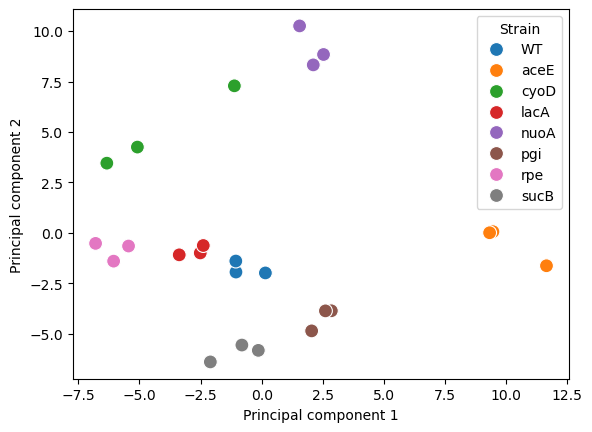

In [22]:
sns.scatterplot(data = pca_df, x = 'Principal component 1', y = 'Principal component 2', hue = 'Strain', s = 100)

<Axes: xlabel='Principal component 1', ylabel='Principal component 3'>

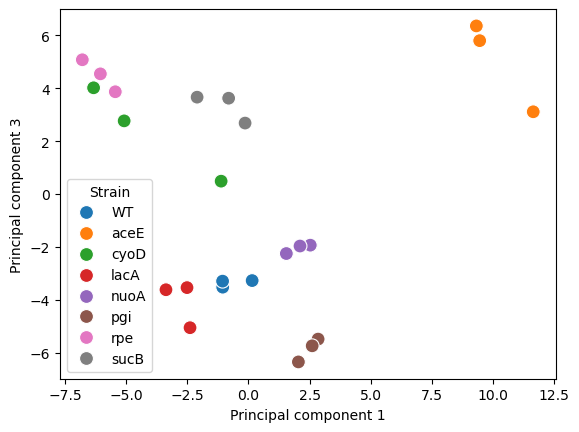

In [23]:
sns.scatterplot(data = pca_df, x = 'Principal component 1', y = 'Principal component 3', hue = 'Strain', s = 100)

In [24]:
pca.components_

array([[-0.03603235,  0.03593583, -0.12182701, -0.04535609, -0.06178398,
         0.13683752, -0.02550427, -0.04570707, -0.13158451, -0.09627395,
         0.07040534,  0.01230505,  0.00511265,  0.01590903,  0.09847667,
        -0.05078835, -0.06322359, -0.17436348,  0.07883101,  0.14209093,
        -0.01814673, -0.0746827 ,  0.02342113,  0.00427871, -0.00953166,
        -0.03743532,  0.08088103, -0.07521269,  0.05487127, -0.15618357,
        -0.12751206, -0.0425494 , -0.07518288, -0.0260191 ,  0.02857557,
        -0.0518735 , -0.14462734, -0.11028473, -0.08029955, -0.02423353,
         0.02439678, -0.00386885,  0.09424536, -0.1046203 , -0.17308012,
        -0.10297954, -0.1291838 ,  0.0037372 ,  0.14019422, -0.12764349,
        -0.11095913, -0.10662529, -0.12323635,  0.02735254, -0.11323482,
        -0.04103371, -0.04430757,  0.02636627,  0.04301022, -0.03528987,
         0.00478542, -0.03533051, -0.11473578, -0.1211579 , -0.0167143 ,
         0.03676484,  0.16871421, -0.0908459 , -0.1

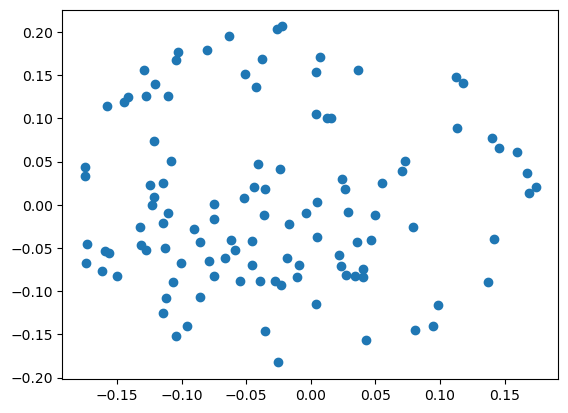

In [25]:
plt.scatter(pca.components_[0, :], pca.components_[1, :])

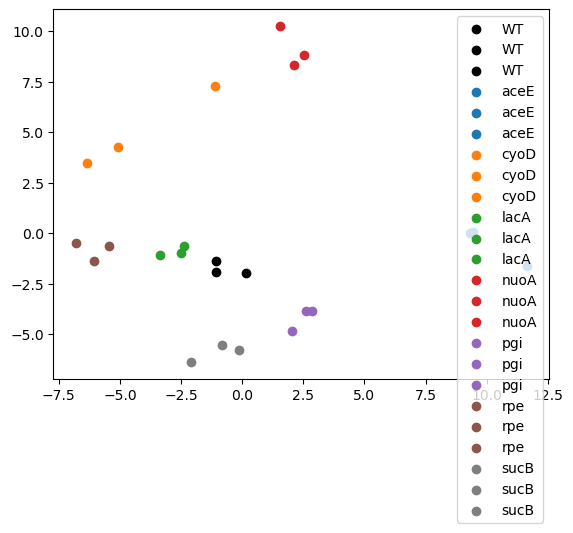

In [26]:
fig, ax =  plt.subplots(1)
for i, sample in enumerate(count_df.columns):
    sample_id = id_mapping[sample]
    strain = sample_id.split(': ')[1]
    j = int(re.search(r'\d+', sample_id).group())
    if strain == 'WT':
        ax.scatter(Xn[i,0], Xn[i, 1], label = strain, c = 'k')
    else:
        ax.scatter(Xn[i,0], Xn[i, 1], label = strain, c = f'C{j-1}')
    plt.legend()
    

In [73]:
id_mapping

{'SR_MPTA_020204_11A-2_WT_22': '11A-2: WT',
 'SR_MPTA_020204_11B-2_WT_23': '11B-2: WT',
 'SR_MPTA_020204_11C-2_WT_24': '11C-2: WT',
 'SR_MPTA_020204_12A-1_pool_A_25': '12A-1: pool',
 'SR_MPTA_020204_12B-1_pool_B_26': '12B-1: pool',
 'SR_MPTA_020204_12C-1_pool_C_27': '12C-1: pool',
 'SR_MPTA_020204_1A-2_aceE_1': '1A-2: aceE',
 'SR_MPTA_020204_1B-2_aceE_2': '1B-2: aceE',
 'SR_MPTA_020204_1C-2_aceE_3': '1C-2: aceE',
 'SR_MPTA_020204_2A-2_cyoD_4': '2A-2: cyoD',
 'SR_MPTA_020204_2B-2_cyoD_5': '2B-2: cyoD',
 'SR_MPTA_020204_2C-2_cyoD_6': '2C-2: cyoD',
 'SR_MPTA_020204_3A-2_lacA_7': '3A-2: lacA',
 'SR_MPTA_020204_3B-2_lacA_8': '3B-2: lacA',
 'SR_MPTA_020204_3C-2_lacA_9': '3C-2: lacA',
 'SR_MPTA_020204_4A-2_nuoA_10': '4A-2: nuoA',
 'SR_MPTA_020204_4B-2_nuoA_11': '4B-2: nuoA',
 'SR_MPTA_020204_4C-2_nuoA_12': '4C-2: nuoA',
 'SR_MPTA_020204_5A-2_pgi_13': '5A-2: pgi',
 'SR_MPTA_020204_5B-2_pgi_14': '5B-2: pgi',
 'SR_MPTA_020204_5C-2_pgi_15': '5C-2: pgi',
 'SR_MPTA_020204_6A-2_rpe_16': '6A-2: rpe',

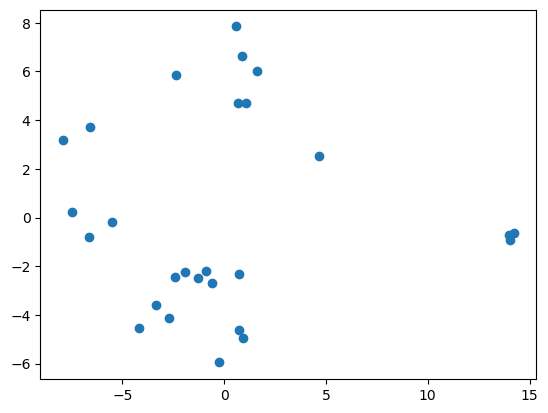

In [69]:
plt.scatter(Xn[:,0], Xn[:,1])